<a href="https://colab.research.google.com/github/Hoffmannzz/Rice-Grain-Images-Classification-with-CNN/blob/main/Rice_Image_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Rice Image Classification and Its Implications in Smart Agriculture**

This project leverages Convolutional Neural Networks (CNN) to accurately identify and classify rice grains. By implementing a deep learning approach, I've developed a model capable of distinguishing between various rice types based on grain images. The code encompasses the entire pipeline from data preprocessing, model training, to final predictions. It's designed for scalability and can be adapted to classify other granular materials. This repository serves as a comprehensive guide for enthusiasts and researchers interested in applying CNNs for agricultural product classification.

In [ ]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import transforms, utils, datasets, models
from torch.autograd import Variable
from keras.optimizers import Adam
import glob
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pathlib

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Loading Data**

In [ ]:
# Set the path to the dataset in Google Drive
path = pathlib.Path("/content/drive/MyDrive/Rice_Image_Dataset")

# Create lists of file paths for each rice type
arborio = list(path.glob('Arborio/*'))
basmati = list(path.glob('Basmati/*'))
ipsala = list(path.glob('Ipsala/*'))
jasmine = list(path.glob('Jasmine/*'))
karacadag = list(path.glob('Karacadag/*'))

# Combine all lists into a single list
total_list = arborio + basmati + ipsala + jasmine + karacadag


In [ ]:
#understand the dataset
data_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor()
    ]
)

model_dataset = datasets.ImageFolder(path, transform=data_transform)

image, label = model_dataset[0]
print(f"Image Size: {image.shape}")
print(f"Label: {label}")
print(image)

Image Size: torch.Size([3, 250, 250])
Label: 0
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [ ]:
#transfrom data
data_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((64,64)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]
        ),
    ]
)
BATCH_SIZE=64
num_workers = 8

model_dataset = datasets.ImageFolder(path, transform=data_transform)
train_count = int(0.6 * len(total_list))
valid_count = int(0.2 * len(total_list))
test_count = len(total_list) - train_count - valid_count
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(model_dataset, (train_count, valid_count, test_count))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=num_workers,shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset , batch_size=BATCH_SIZE, num_workers=num_workers,shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### **Visualizing the Data**

In [ ]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
images.shape # (number of examples: 256, number of channels: 3, pixel sizes: 64x64)

(64, 3, 64, 64)

In [ ]:
# specify the image classes
classes = ['arborio', 'basmati', 'ipsala', 'jasmine',  'karacadag']
classes

['arborio', 'basmati', 'ipsala', 'jasmine', 'karacadag']

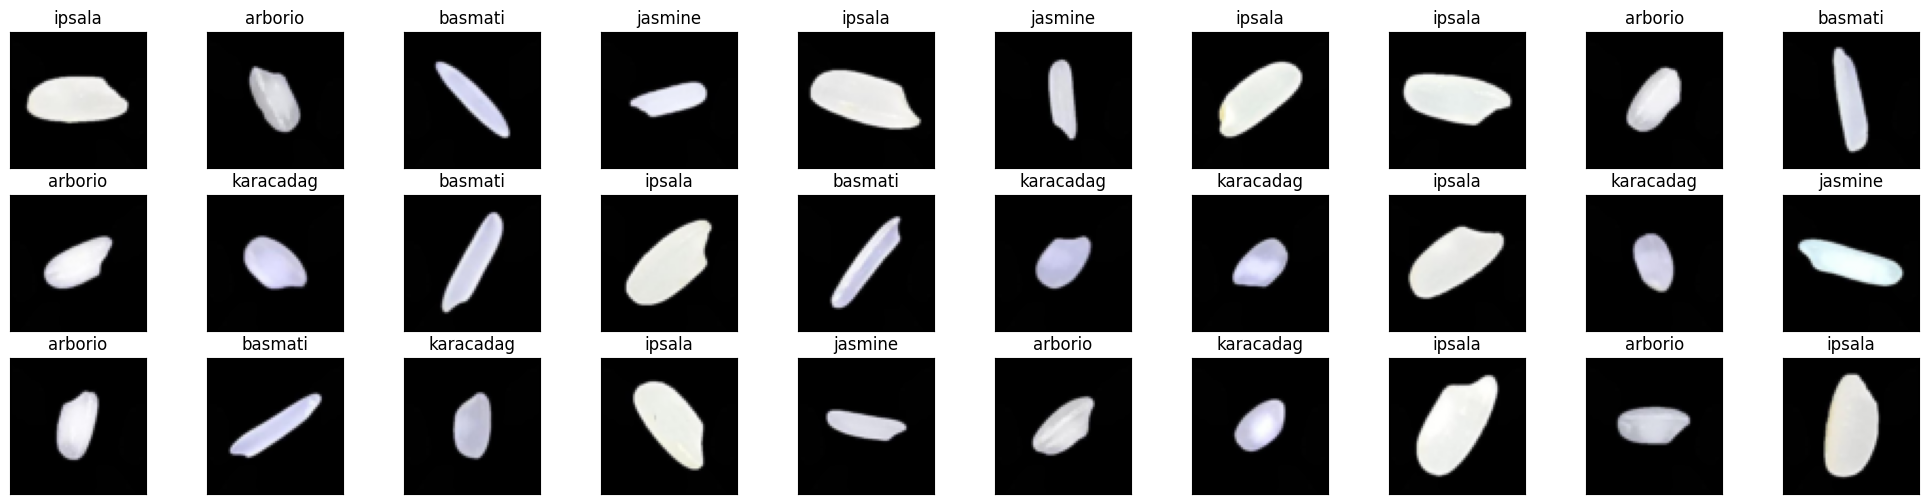

In [ ]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 6))
# display 30 images
for idx in np.arange(30):
    ax = fig.add_subplot(3, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

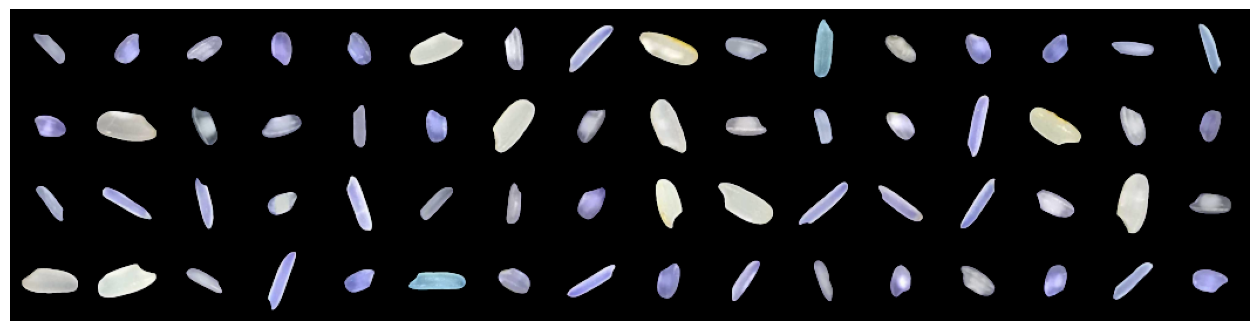

In [ ]:
for item in train_loader:
    plt.figure(figsize=(16, 8))
    image, _ = item
    plt.imshow(make_grid(image, nrow=16).permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    break

### **Building the Model Architecture**

In [ ]:
#build model
class ConvNN(nn.Module):
    def __init__(self):
        super().__init__() #Inheritance

        self.conv1 = nn.Conv2d(in_channels=3,out_channels=12,padding=1,kernel_size=3)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(in_channels=12,out_channels=20,padding=1,kernel_size=3)
        self.bn2=nn.BatchNorm2d(num_features=20)
        self.relu2=nn.ReLU()
        self.dropout = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(in_channels=20,out_channels=32,padding=1,kernel_size=3)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.25)


        self.fc1=nn.Linear(32*16*16, 5)

    def forward(self, x):

        output=self.conv1(x)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool1(output)
        output=self.dropout(output)

        output=self.conv2(output)
        output=self.bn2(output)
        output=self.relu2(output)
        output=self.dropout(output)

        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=self.pool3(output)
        output=self.dropout(output)


        output = torch.flatten(output, 1)
        output = output.view(-1,32*16*16)
        output = self.dropout(output)
        output = self.fc1(output)


        return output

In [ ]:
model = ConvNN()
model

ConvNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=5, bias=True)
)

In [ ]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

### **Training the Network**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=0.000005)

In [ ]:
# number of epochs to train the model
n_epochs = 35

valid_loss_min = np.Inf # track change in validation loss
train_losses = []
valid_losses = []
valid_accuracies = []
count = 0


for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0) #here we multiply the batch size to compute the total loss

    ######################
    # validate the model #
    ######################
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
      for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

        # Compute validation accuracy
        _, predicted = torch.max(output.data, 1)
        total_val += target.size(0)
        correct_val += (predicted == target).sum().item()


    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler) #here we divide the total samples to get the average loss
    valid_loss = valid_loss/len(valid_loader.sampler)

    # calculate validation accuracy
    val_accuracy = 100 * correct_val / total_val

    # Store metrics
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accuracies.append(val_accuracy)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}%'.format(
        epoch, train_loss, valid_loss, val_accuracy))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))

        torch.save(model.state_dict(), 'Best_ricemodel.pt')
        valid_loss_min = valid_loss

    # Terminate when accuracy is high enough (99.3%)
    count += 1
    if val_accuracy >= 99.5:
        break


n_epochs = count

Epoch: 1 	Training Loss: 0.348995 	Validation Loss: 0.191536 	Validation Accuracy: 93.848717%
Validation loss decreased (inf --> 0.191536).  Saving model ...
Epoch: 2 	Training Loss: 0.079558 	Validation Loss: 0.121642 	Validation Accuracy: 96.661113%
Validation loss decreased (0.191536 --> 0.121642).  Saving model ...
Epoch: 3 	Training Loss: 0.056497 	Validation Loss: 0.112482 	Validation Accuracy: 96.401200%
Validation loss decreased (0.121642 --> 0.112482).  Saving model ...
Epoch: 4 	Training Loss: 0.046987 	Validation Loss: 0.080165 	Validation Accuracy: 97.727424%
Validation loss decreased (0.112482 --> 0.080165).  Saving model ...
Epoch: 5 	Training Loss: 0.042636 	Validation Loss: 0.075482 	Validation Accuracy: 97.687438%
Validation loss decreased (0.080165 --> 0.075482).  Saving model ...
Epoch: 6 	Training Loss: 0.037180 	Validation Loss: 0.074132 	Validation Accuracy: 97.767411%
Validation loss decreased (0.075482 --> 0.074132).  Saving model ...
Epoch: 7 	Training Loss: 0.

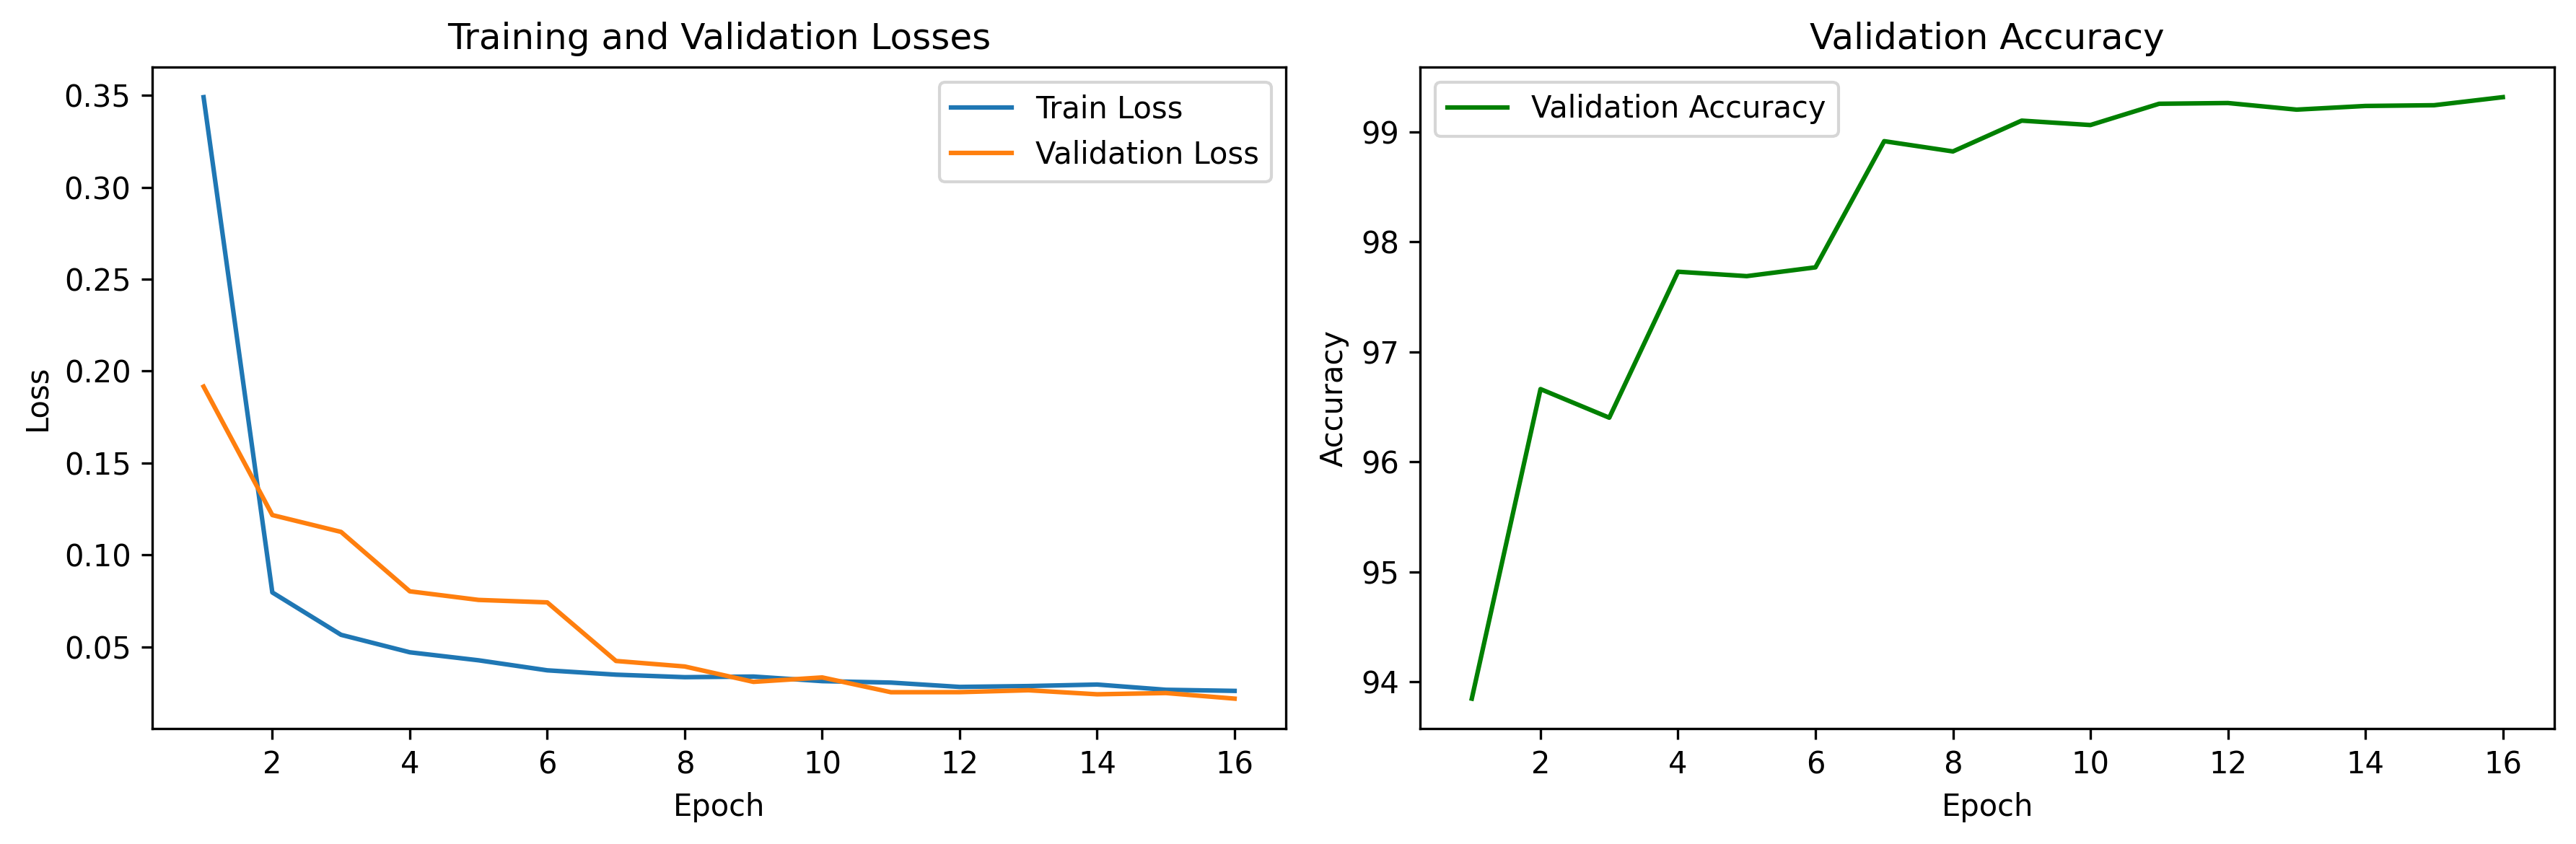

In [ ]:
# Plotting
plt.figure(figsize=(12, 4), dpi=300)

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), valid_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.load_state_dict(torch.load('Best_ricemodel.pt'))

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
size=len(test_dataset)
predictions = np.zeros(size)
all_classes = np.zeros(size)
all_proba = np.zeros((size,5))
idx=0
model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    predictions[idx:idx+len(target)]=pred.to('cpu').numpy()
    all_classes[idx:idx+len(target)]=target.to('cpu').numpy()
    all_proba[idx:idx+len(target),:]=output.to('cpu').detach().numpy()
    idx+=len(target)

    # calculate test accuracy for each object class
    for i in range(len(target)):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

### **Visualizing the Classified Images**

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 6))
for idx in np.arange(20):
    ax = fig.add_subplot(3, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

### **Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def make_fig_cm(cm):
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    tick_marks = np.arange(5);
    plt.xticks(tick_marks, classes, rotation=90);
    plt.yticks(tick_marks, classes, rotation=0);
    plt.tight_layout();
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        coeff = f'{cm[i, j]}'
        plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual');
    plt.xlabel('Predicted');

In [ ]:
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)